# 実習4 Baysian Online (異常検知）

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
class BayesianOnlineChangePointDetection(object):
    T = 0  # 観測時間
        
    def __init__(self, hazard_func, distribution):        
        self.beliefs = np.zeros((2,2))
        self.beliefs[0, 0] = 1.
        self.hazard_func = hazard_func
        self.distribution = distribution
        
    def reset_params(self):
        self.T = 0
        self.beliefs = np.zeros((2,2))
        self.beliefs[0, 0] = 1.

    def _expand_belief_matrix(self):
        n_row, n_col = self.beliefs.shape
        rows = np.zeros((1, 2))
        cols = np.zeros((n_row+1, 1))
        self.beliefs = np.concatenate((self.beliefs, rows), axis=0)

    def _shift_belief_matrix(self):
        current_belief = self.beliefs[:, 0]
        self.beliefs[:, 0] = self.beliefs[:, 1]
        self.beliefs[:, 1] = 0
        return current_belief

    def _update_beliefs(self, hazard, pred_probs):
        self._expand_belief_matrix()

        self.beliefs[1:self.T+2, 1] = \
            self.beliefs[:self.T+1, 0] * pred_probs * (1 - hazard)

        self.beliefs[0, 1] = \
            (self.beliefs[:self.T+1, 0] * pred_probs * hazard).sum()
        
        self.beliefs[:, 1] = self.beliefs[:, 1] / self.beliefs[:, 1].sum()
        
    def update(self, x):
        pred_probs = self.distribution.pdf(x)
        hazard = self.hazard_func(np.arange(self.T+1))
        self._update_beliefs(hazard, pred_probs)
        self.distribution.update_params(x)
        max_belief_idx = \
            np.where(self.beliefs[:, 0]==self.beliefs[:, 0].max())[0]
        current_belief = self._shift_belief_matrix()
    
        self.T += 1
        return max_belief_idx, current_belief

In [3]:
class StudentT(object):
    def __init__(self, mu0=0, kappa0=1, alpha0=1, beta0=1):
        self.mu0    = np.array([mu0])
        self.kappa0 = np.array([kappa0])
        self.alpha0 = np.array([alpha0])
        self.beta0  = np.array([beta0])
        self.reset_params()
    
    def reset_params(self):
        self.muT    = self.mu0.copy()
        self.kappaT = self.kappa0.copy()
        self.alphaT = self.alpha0.copy()
        self.betaT  = self.beta0.copy()
        
    def pdf(self, x):
        return stats.t.pdf(
            x,
            loc=self.muT,
            df=2 * self.alphaT,
            scale=np.sqrt(self.betaT * (self.kappaT + 1) / (self.alphaT * self.kappaT)),
        )
        
    def update_params(self, x):
        self.betaT = np.concatenate(
            [self.beta0, 
             (self.kappaT
              + (self.kappaT * (x - self.muT)**2) / (2 * (self.kappaT + 1)))
            ])
        self.muT = np.concatenate(
            [self.mu0, (self.kappaT * self.muT + x) / (self.kappaT + 1) ])
        self.kappaT = np.concatenate([self.kappa0, self.kappaT + 1 ])
        self.alphaT = np.concatenate([self.alpha0, self.alphaT + 0.5 ])

In [4]:
def constant_hazard(r, _lambda):
    if isinstance(r, np.ndarray):
        shape = r.shape
    else:
        shape = 1
    # 変化点確率の計算
    probability = np.ones(shape) / _lambda
    return probability

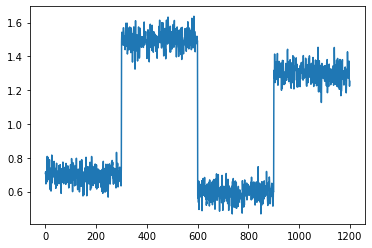

In [5]:
test_signal = np.concatenate(
    [np.random.normal(0.7, 0.05, 300), 
     np.random.normal(1.5, 0.05, 300),
     np.random.normal(0.6, 0.05, 300),
     np.random.normal(1.3, 0.05, 300)])
plt.plot(test_signal)

In [6]:
hazard_func = lambda r: constant_hazard(r, _lambda=300)
distribution = StudentT()

In [7]:
distribution.reset_params()

bcp = BayesianOnlineChangePointDetection(hazard_func, distribution)
bcp.reset_params()

maxes = np.empty(test_signal.shape)
beliefs = []
beliefs.append(bcp.beliefs[:,0])

for i, d in enumerate(test_signal):
    maxes[i], current_belief = bcp.update(d)
    beliefs.append(current_belief)

In [8]:
max_len = beliefs[-1].shape[0]
belief_matrix = np.zeros((max_len-1, max_len-1))

for i, belief in enumerate(beliefs):
    belief_matrix[:i+1, i] = belief[:-1]

<ipython-input-9-b1f4053137bf>:4: RuntimeWarning: divide by zero encountered in log
  ax[1].imshow(-np.log(belief_matrix), interpolation='none', aspect='auto',


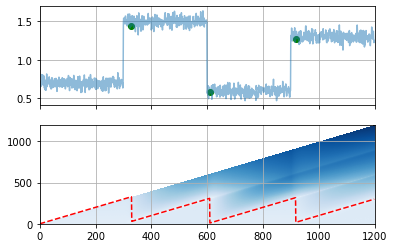

In [9]:
fig, ax = plt.subplots(nrows = 2, sharex = True)

ax[0].plot(test_signal, alpha=0.5, label="observation")
ax[1].imshow(-np.log(belief_matrix), interpolation='none', aspect='auto',
               origin='lower', cmap=plt.cm.Blues, label="belief")
ax[1].plot(maxes, '--', color='r', label="run length")
ax[1].set_xlim([0, len(test_signal)])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[0].grid()
ax[1].grid()
index_changes = np.where(np.diff(maxes)<0)[0]
ax[0].scatter(index_changes, test_signal[index_changes], c='green', label="change point")

In [10]:
test_signal = np.array([0,0,0,2,3,100,100,115,112,117,120,115,125,140,5,4,0])

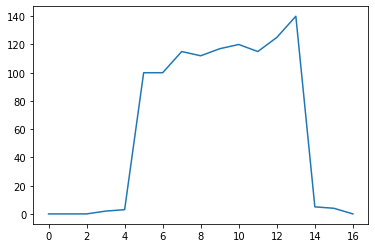

In [11]:
plt.plot(test_signal)

In [12]:
hazard_func = lambda r: constant_hazard(r, _lambda=50)
distribution = StudentT()

In [13]:
distribution.reset_params()

bcp = BayesianOnlineChangePointDetection(hazard_func, distribution)
bcp.reset_params()

maxes = np.empty(test_signal.shape)
beliefs = []
beliefs.append(bcp.beliefs[:,0])
for i, d in enumerate(test_signal):
    maxes[i], current_belief = bcp.update(d)
    beliefs.append(current_belief)

In [14]:
max_len = beliefs[-1].shape[0]
belief_matrix = np.zeros((max_len-1, max_len-1))

for i, belief in enumerate(beliefs):
    belief_matrix[:i+1, i] = belief[:-1]

<ipython-input-15-b1f4053137bf>:4: RuntimeWarning: divide by zero encountered in log
  ax[1].imshow(-np.log(belief_matrix), interpolation='none', aspect='auto',


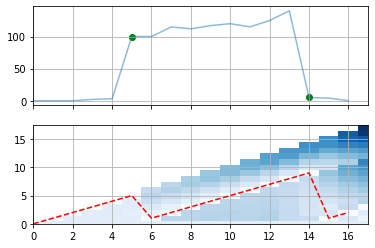

In [15]:
fig, ax = plt.subplots(nrows = 2, sharex = True)

ax[0].plot(test_signal, alpha=0.5, label="observation")
ax[1].imshow(-np.log(belief_matrix), interpolation='none', aspect='auto',
               origin='lower', cmap=plt.cm.Blues, label="belief")
ax[1].plot(maxes, '--', color='r', label="run length")
ax[1].set_xlim([0, len(test_signal)])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[0].grid()
ax[1].grid()
index_changes = np.where(np.diff(maxes)<0)[0]
ax[0].scatter(index_changes, test_signal[index_changes], c='green', label="change point")